In [1]:
import torch
import numpy as np

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **NEURAL NETWORK**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, layer_size):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(input_dim, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, output_dim)


    def forward(self, input_0, input_boundary, dt, IRK_weights):
        u_0, _ = self.forward_iteration(input_0, dt, IRK_weights, True)
        _, u_1 = self.forward_iteration(input_boundary)
        return u_0, u_1


    def forward_iteration(self, x, dt=None, IRK_weights=None, pred_0_flag=False):
        u_0=None
        
        x.requires_grad_(True)

        s = nn.Tanh()(self.fc1(x.float()))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        u_1 = self.fc4(s)

        if pred_0_flag:
            u = u_1[:, :-1]
            u_x = self.fwd_gradients_0(u, x)
            u_xx = self.fwd_gradients_0(u_x, x)
            f = - u * u_x + (0.01/np.pi)*u_xx
            u_0 = u_1 - dt * torch.mm(f.double(), IRK_weights.double())
            u_1=None

        return u_0, u_1


    def fwd_gradients_0(self, U, x):
        z = torch.ones(U.shape).to(device).requires_grad_(True)
        g = autograd.grad(U, x, grad_outputs=z, create_graph=True)[0]
        return autograd.grad(g, z, grad_outputs=torch.ones(g.shape).to(device), create_graph=True)[0]
    

    def predict(self, x):
        s = nn.Tanh()(self.fc1(x.float()))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        u = self.fc4(s)
        return u

# **OPTIMIZATION**

In [6]:
from torch.optim import LBFGS
from time import time
from tqdm.notebook import tqdm as tqdm

In [7]:
class Train():
    def __init__(self, network, input_0, target_0, input_boundary, dt, q):
        self.net = network

        self.lbfgs_optim = LBFGS(self.net.parameters(), lr=1, max_iter=50000, line_search_fn='strong_wolfe')

        tmp = np.float32(np.loadtxt('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = torch.from_numpy(np.reshape(tmp[0:q**2+q], (q+1, q)).T).to(device)
        self.IRK_times = torch.from_numpy(tmp[q**2+q:])

        self.train_input_0, self.train_target_0 = input_0.to(device), target_0.to(device)

        self.input_boundary = input_boundary.to(device)

        self.dt = torch.tensor(dt).to(device)
        self.i = 0

        
    def train(self): 
        start_time = time()

        self.train_iteration(self.train_input_0, self.train_target_0, self.input_boundary)

        end_time = time()
        print('Time:', end_time - start_time)     


    def train_iteration(self, input_0, target_0, input_1):
                
        def closure(): 
            if torch.is_grad_enabled():
                self.lbfgs_optim.zero_grad()
            predict_0, predict_1 = self.net(input_0, input_1, self.dt, self.IRK_weights)
            loss = self.loss_function(predict_0, target_0, predict_1)
            if loss.requires_grad:
                loss.backward()
            return loss
        self.lbfgs_optim.step(closure)


    def loss_function(self, predict_0, target_0, predict_1): 
        loss1 = torch.sum(torch.square(predict_0- target_0)) 
        loss2 = torch.sum(torch.square(predict_1))
        return loss1+loss2


# **MAIN**


## DATA PREPERATION

In [8]:
import scipy.io

COLLECTING THE DATA

In [9]:
data = scipy.io.loadmat('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/appendix/Data/burgers_shock.mat')

t_data = data['t']  # SHAPE (100, 1)
x_data = data['x']  # SHAPE (256,1)
u_data = np.real(data['usol']).T  # SHAPE (100, 256)

lb = np.array([-1.0])
ub = np.array([1.0])
N = 250 #number of x data points

In [10]:
idx_x = np.random.choice(u_data.shape[1], N, replace=False) 
x_0 = x_data[idx_x, :]
x_0 = torch.from_numpy(x_0)
print('INIT INPUT SHAPE:', x_0.shape)

idx_t0 = 10
idx_t1 = 90
u_0 = u_data[idx_t0:idx_t0+1, idx_x].T
u_0 = torch.from_numpy(u_0)
print('INIT TARGET SHAPE:', u_0.shape)

x_boundary = torch.from_numpy(np.vstack((lb, ub)))
print('BOUNDARIES:\n', np.array(x_boundary))
dt = t_data[idx_t1] - t_data[idx_t0]
print('dt:', dt.item())

INIT INPUT SHAPE: torch.Size([250, 1])
INIT TARGET SHAPE: torch.Size([250, 1])
BOUNDARIES:
 [[-1.]
 [ 1.]]
dt: 0.8


## TRAINING

INITIALIZE NETWORK

In [11]:
q = 500
input_dim, output_dim, layer_size = 1, q+1, 100
net = PINN(input_dim, output_dim, layer_size).to(device)

TRAINING NETWORK

In [12]:
train = Train(net, x_0, u_0, x_boundary, dt, q)

In [13]:
train.train()

Time: 504.84653973579407


## PLOTTING

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

In [15]:
def plot_grid(u_plot, t_data, X_grid, T_grid, string_title, t_index_low=None, t_index_high=None):
    fig = plt.subplots(figsize=(8, 4))
    plt.contourf(T_grid, X_grid, u_plot, 1000, cmap=plt.get_cmap('Spectral'))
    plt.colorbar()
    plt.ylabel(r'$x$')
    plt.xlabel(r'$t$')
    plt.title(string_title, fontsize = 15) 

    try:
        line = np.linspace(x_data.min(), x_data.max(), 2)[:,None]
        fig[1].plot(t_data[t_index_low]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_high]*np.ones((2,1)), line, 'k--', linewidth = 1)
    except Exception:
        pass    
    

    plt.show()
    plt.draw()
    #fig[0].savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Burgers_Discrete_Inference/' + string_title.format(1000), bbox_inches='tight')
    plt.close()

def plot_time_step(x_data, x_input, t_data, u_data, u_pred, t_index, x_lb, x_ub, y_lb, y_ub, data_font, label):
    fig = plt.subplots(figsize=(2.6, 2.6))
    fig[1].plot(x_data, u_data[t_index,:].T, 'b-', linewidth = 2, label = 'Exact') 
    fig[1].plot(x_input, u_pred[: ,-1].cpu().detach().numpy(), data_font, linewidth = 2, label = label)      
    fig[1].set_xlabel('$x$')
    fig[1].set_ylabel('$u(t,x)$')    
    fig[1].set_title('$t = %.2f$' % (t_data[t_index]), fontsize = 15)
    fig[1].set_xlim([x_lb, x_ub])
    fig[1].set_ylim([y_lb, y_ub])
    fig[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)
    plt.show()
    #fig[1].figure.savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Burgers_Discrete_Inference/target_v_pred_t%.2f' % t_data[t_index].item() + '.png', bbox_inches='tight')

Locator attempting to generate 1001 ticks ([-1.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


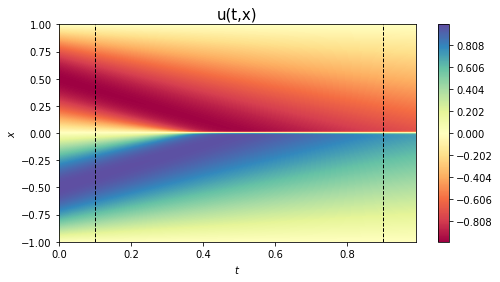

In [16]:
X, T = np.meshgrid(x_data, t_data)
plot_grid(u_data, t_data, X, T, 'u(t,x)', idx_t0, idx_t1)

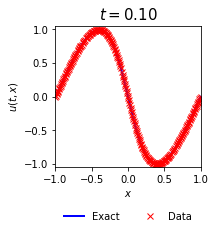

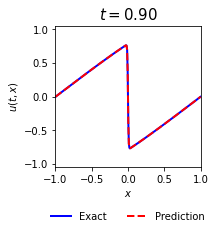

In [17]:
u1_pred = net.predict(torch.from_numpy(x_data).to(device))
plot_time_step(x_data, x_0.cpu().detach().numpy(), t_data, u_data, u_0, idx_t0, x_data.min(), x_data.max(), u_data.min()*1.05, u_data.max()*1.05, 'rx', 'Data')
plot_time_step(x_data, x_data, t_data, u_data, u1_pred, idx_t1, x_data.min(), x_data.max(), u_data.min()*1.05, u_data.max()*1.05, 'r--', 'Prediction')

##ERROR


In [18]:
criterion = nn.MSELoss()

Error = criterion( u1_pred[:,-1].cpu().detach(), torch.from_numpy(u_data[idx_t1,:]))

print('L2 Norm Error:', Error.item())

Error_relative = Error / (torch.mean(torch.abs(torch.from_numpy(u_data[idx_t1,:]))))
print('Relative L2 Norm Error:', Error_relative.item())

L2 Norm Error: 1.0425237616540782e-08
Relative L2 Norm Error: 2.629483728352803e-08
